# ICS5110: Applied Machine Learning

Peter Galea St. John: 288098m\
Christian A. Vella


In [1]:
# Import some necessary libraries

import pandas as pd
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

######-ANN
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


######-RF
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Data Preparation

In [2]:
 with open('Cleaned-Data.csv') as csv_file:
    data = list(csv.reader(csv_file, delimiter='\t'))
    r = len(data)

In [3]:
df = pd.read_csv('Cleaned-Data.csv',na_values="?" )

In [4]:
df.head()

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,...,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes,Country
0,1,1,1,1,1,0,1,1,1,1,...,1,0,1,0,0,0,0,0,1,China
1,1,1,1,1,1,0,1,1,1,1,...,1,0,1,0,0,0,0,1,0,China
2,1,1,1,1,1,0,1,1,1,1,...,1,0,1,0,0,0,1,0,0,China
3,1,1,1,1,1,0,1,1,1,1,...,1,0,0,1,0,0,0,0,1,China
4,1,1,1,1,1,0,1,1,1,1,...,1,0,0,1,0,0,0,1,0,China


In [5]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,Country
0,China
1,China
2,China
3,China
4,China


In [6]:
obj_df["Country"].value_counts() #plot distribution

Other                 31680
France                31680
Germany               31680
Italy                 31680
Iran                  31680
Republic of Korean    31680
UAE                   31680
China                 31680
Spain                 31680
Other-EUR             31680
Name: Country, dtype: int64

In [7]:
cleanup_Countries = {"Country": {"China":0, "UAE":1, "Iran":2, "France":3, "Republic of Korean":4, "Spain":5, "Italy":6, "Germany":7, "Other-EUR":8, "Other":9}}

In [8]:
obj_df = obj_df.replace(cleanup_Countries)

In [9]:
obj_df.head()

,Country
0,0
1,0
2,0
3,0
4,0


In [10]:
df["Country"] = obj_df

In [11]:
severity_columns = df.filter(like='Severity_').columns
gender_columns = df.filter(like='Gender_').columns

df['Severity_None'].replace({1:'0',0:'No'},inplace =True)
df['Severity_Mild'].replace({1:'1',0:'No'},inplace =True)
df['Severity_Moderate'].replace({1:'2',0:'No'},inplace =True)
df['Severity_Severe'].replace({1:'3',0:'No'},inplace =True)

df['Condition'] = df[severity_columns].values.tolist()

df.drop(columns=['Severity_None','Severity_Mild','Severity_Moderate','Severity_Severe'])

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,...,Age_25-59,Age_60+,Gender_Female,Gender_Male,Gender_Transgender,Contact_Dont-Know,Contact_No,Contact_Yes,Country,Condition
0,1,1,1,1,1,0,1,1,1,1,...,0,0,0,1,0,0,0,1,0,"[1, No, No, No]"
1,1,1,1,1,1,0,1,1,1,1,...,0,0,0,1,0,0,1,0,0,"[1, No, No, No]"
2,1,1,1,1,1,0,1,1,1,1,...,0,0,0,1,0,1,0,0,0,"[1, No, No, No]"
3,1,1,1,1,1,0,1,1,1,1,...,0,0,0,1,0,0,0,1,0,"[No, 2, No, No]"
4,1,1,1,1,1,0,1,1,1,1,...,0,0,0,1,0,0,1,0,0,"[No, 2, No, No]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316795,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,9,"[No, No, No, 3]"
316796,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,9,"[No, No, No, 3]"
316797,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,9,"[No, No, 0, No]"
316798,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,9,"[No, No, 0, No]"


In [12]:
def removing(list1):
    list1 = set(list1) 
    list1.discard("No")
    a = ''.join(list1)
    return a

In [13]:
df['Condition'] = df['Condition'].apply(removing)

In [14]:
df.head()

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,...,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes,Country,Condition
0,1,1,1,1,1,0,1,1,1,1,...,0,1,No,No,No,0,0,1,0,1
1,1,1,1,1,1,0,1,1,1,1,...,0,1,No,No,No,0,1,0,0,1
2,1,1,1,1,1,0,1,1,1,1,...,0,1,No,No,No,1,0,0,0,1
3,1,1,1,1,1,0,1,1,1,1,...,0,No,2,No,No,0,0,1,0,2
4,1,1,1,1,1,0,1,1,1,1,...,0,No,2,No,No,0,1,0,0,2


In [15]:
headers= df.columns.tolist()

In [16]:
df = df.sample(n=30000, replace=True,random_state=1)

In [17]:
X= pd.DataFrame.to_numpy(df.drop(['Condition'],axis=1))
y= pd.DataFrame.to_numpy(df['Condition'])

In [18]:
X= np.delete(X,19,1)
X= np.delete(X,19,1)
X= np.delete(X,19,1)
X= np.delete(X,19,1)

In [19]:
print(headers)
headers.remove('Severity_Mild')
headers.remove('Severity_Moderate')
headers.remove('Severity_None')
headers.remove('Severity_Severe')
headers.remove('Condition')
print(headers)

['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat', 'None_Sympton', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea', 'None_Experiencing', 'Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+', 'Gender_Female', 'Gender_Male', 'Gender_Transgender', 'Severity_Mild', 'Severity_Moderate', 'Severity_None', 'Severity_Severe', 'Contact_Dont-Know', 'Contact_No', 'Contact_Yes', 'Country', 'Condition']
['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat', 'None_Sympton', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea', 'None_Experiencing', 'Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+', 'Gender_Female', 'Gender_Male', 'Gender_Transgender', 'Contact_Dont-Know', 'Contact_No', 'Contact_Yes', 'Country']


In [20]:
y.shape

(30000,)

____

## Feature Selection: Chi Square

In [21]:
def get_max(x):
    max_val = 0
    for i in x:
        if i>max_val:
            max_val = i
    return max_val

In [22]:
def get_min(x):
    min_val = 99
    for i in x:
        if i<min_val:
            min_val = i
    return min_val

In [23]:
y = y.astype(np.int)

### Contingency Table

In [24]:
contingency_table = {headers[0]:{0,0}}

for x_col in range(X.shape[1]):
    col = X[:,x_col]
    h = headers[x_col]
    
    contingency_table[headers[x_col]] = {}
    
    for val_x in range(get_max(col)+1):
        count=0
        for val_y in range(get_max(y)+1):
            
            contingency_table[headers[x_col]][val_x,val_y]=  0

In [25]:
for x_col in range(X.shape[1]):
    col = X[:,x_col]
    print(headers[x_col])
    
    for i in range(col.shape[0]):
        contingency_table[headers[x_col]][col[i],y[i]] +=1

Fever
Tiredness
Dry-Cough
Difficulty-in-Breathing
Sore-Throat
None_Sympton
Pains
Nasal-Congestion
Runny-Nose
Diarrhea
None_Experiencing
Age_0-9
Age_10-19
Age_20-24
Age_25-59
Age_60+
Gender_Female
Gender_Male
Gender_Transgender
Contact_Dont-Know
Contact_No
Contact_Yes
Country


#### Degrees of Freedom

In [26]:
df ={}

for x_col in range(X.shape[1]):
    col = X[:,x_col]
    print(headers[x_col])
    
    rows = (get_max(col)+1)
    cols = (get_max(y)+1)
    
    df[headers[x_col]] = (rows-1)*(cols-1)
    

Fever
Tiredness
Dry-Cough
Difficulty-in-Breathing
Sore-Throat
None_Sympton
Pains
Nasal-Congestion
Runny-Nose
Diarrhea
None_Experiencing
Age_0-9
Age_10-19
Age_20-24
Age_25-59
Age_60+
Gender_Female
Gender_Male
Gender_Transgender
Contact_Dont-Know
Contact_No
Contact_Yes
Country


Degrees of Freedom for Contingency Tables = (r-1)*(c-1)

In [27]:
print(df)

{'Fever': 3, 'Tiredness': 3, 'Dry-Cough': 3, 'Difficulty-in-Breathing': 3, 'Sore-Throat': 3, 'None_Sympton': 3, 'Pains': 3, 'Nasal-Congestion': 3, 'Runny-Nose': 3, 'Diarrhea': 3, 'None_Experiencing': 3, 'Age_0-9': 3, 'Age_10-19': 3, 'Age_20-24': 3, 'Age_25-59': 3, 'Age_60+': 3, 'Gender_Female': 3, 'Gender_Male': 3, 'Gender_Transgender': 3, 'Contact_Dont-Know': 3, 'Contact_No': 3, 'Contact_Yes': 3, 'Country': 27}


### Expected Values

In [28]:
expected_values = {headers[0]:{0,0}}

for x_col in range(X.shape[1]):
    col = X[:,x_col]
    h = headers[x_col]
    
    expected_values[headers[x_col]] = {}
    Total = np.sum(list(contingency_table[headers[x_col]].values()))
    rowstotal = []
    colstotal = []
    
    for val_x in range(get_max(col)+1):
        
        for val_y in range(get_max(y)+1):
            rowstotal.append(contingency_table[headers[x_col]][val_x,val_y]) 
            
    for val_y in range(get_max(y)+1):
        
        for val_x in range(get_max(col)+1):
            colstotal.append(contingency_table[headers[x_col]][val_x,val_y])
    
    for val_x in range(get_max(col)+1):
        
        for val_y in range(get_max(y)+1):
            p = (rowstotal[val_x]/Total)*(colstotal[val_y]/Total)
            expected_values[headers[x_col]][val_x,val_y]=  p*Total
            

In [29]:
print(expected_values)

{'Fever': {(0, 0): 935.6268000000001, (0, 1): 415.5398, (0, 2): 895.1854, (0, 3): 419.7782, (1, 0): 895.1854, (1, 1): 397.57856666666663, (1, 2): 856.4920333333332, (1, 3): 401.63376666666665}, 'Tiredness': {(0, 0): 507.00000000000006, (0, 1): 487.63, (0, 2): 483.47, (0, 3): 484.51, (1, 0): 483.47, (1, 1): 464.99896666666666, (1, 2): 461.03203333333335, (1, 3): 462.0237666666667}, 'Dry-Cough': {(0, 0): 377.44083333333333, (0, 1): 480.74633333333327, (0, 2): 364.093, (0, 3): 471.09999999999997, (1, 0): 364.093, (1, 1): 463.7452, (1, 2): 351.21720000000005, (1, 3): 454.44000000000005}, 'Difficulty-in-Breathing': {(0, 0): 468.50003333333336, (0, 1): 487.6199333333334, (0, 2): 463.3764, (0, 3): 467.1254, (1, 0): 463.3764, (1, 1): 482.2872, (1, 2): 458.3088, (1, 3): 462.01680000000005}, 'Sore-Throat': {(0, 0): 906.1932000000002, (0, 1): 423.55060000000003, (0, 2): 886.2062, (0, 3): 407.90860000000004, (1, 0): 886.2062, (1, 1): 414.2087666666667, (1, 2): 866.6600333333332, (1, 3): 398.911766

### Calculate Chi-Square Value

In [30]:
ChiSquare=[]

for x_col in range(X.shape[1]):
    col = X[:,x_col]
    O_E2_divE=[]
    for val_x in range(get_max(col)+1):
        for val_y in range(get_max(y)+1):
            Observed = (contingency_table[headers[x_col]][val_x,val_y])
            Expected = expected_values[headers[x_col]][val_x,val_y]
            O_E = Observed-Expected
            O_E2 = O_E * O_E
            O_E2_divE.append(O_E2/Expected) 
    ChiSquare.append(np.sum(O_E2_divE))

In [31]:
print(ChiSquare)

[168384.33475722797, 178679.82035330965, 224548.69581150825, 183796.39087166867, 169696.80302300825, 847476.2642236493, 158022.19408370458, 206245.6628140825, 205418.30394904967, 159763.70925434006, 576819.4347981558, 255405.17863815947, 254371.45952805958, 252550.4685363993, 256182.32597447364, 251557.21367774432, 164812.12625076916, 164507.8864260789, 163392.77755801764, 165183.30131751084, 163296.80585817815, 164275.56079003363, 1105106.235385769]


### Accept or Reject the Null Hypothesis

With 95% confidence, we will check if the calculated Chi-Square Values will fall in the acceptance or rejection region. If the variables fall in acceptance region (are less than the critical Chi-Square value), we will conclude that the two variables are independent and cannot be selected for training.

In [32]:
drop = []
for h in range(len(headers)):
    print("Testing if variable %s is independent of variable Condition."%headers[h])
    deg = df[headers[h]]
    print("- Degrees of Freedom is %d"%(deg))
    if deg == 3:
        crit_val = 7.82
    if deg == 27:
        crit_val = 40.11
    print("- Critical Value is %d"%(crit_val))
    
    if(ChiSquare[h]>crit_val):
        print("-- Variable %s is dependent on variable Condition."%headers[h])
    else:
        print("-- Variable %s is independent on variable Condition."%headers[h])
        print("DROPPING VARIABLE: %s"%headers[h])
        drop.append(h)
        
X = np.delete(X,drop,1)
    

Testing if variable Fever is independent of variable Condition.
- Degrees of Freedom is 3
- Critical Value is 7
-- Variable Fever is dependent on variable Condition.
Testing if variable Tiredness is independent of variable Condition.
- Degrees of Freedom is 3
- Critical Value is 7
-- Variable Tiredness is dependent on variable Condition.
Testing if variable Dry-Cough is independent of variable Condition.
- Degrees of Freedom is 3
- Critical Value is 7
-- Variable Dry-Cough is dependent on variable Condition.
Testing if variable Difficulty-in-Breathing is independent of variable Condition.
- Degrees of Freedom is 3
- Critical Value is 7
-- Variable Difficulty-in-Breathing is dependent on variable Condition.
Testing if variable Sore-Throat is independent of variable Condition.
- Degrees of Freedom is 3
- Critical Value is 7
-- Variable Sore-Throat is dependent on variable Condition.
Testing if variable None_Sympton is independent of variable Condition.
- Degrees of Freedom is 3
- Critica

---

## Shuffle and Split

In [33]:
def shuffle_and_split(x,y):
    global x_train
    global x_test
    global y_train
    global y_test
    
    N = x.shape[0]
    P = np.arange(0,N,1)
    np.random.shuffle(P)
    lim= int(0.8*N)
    
    x_train = np.copy(x[P[0:lim],:])
    y_train = np.copy(y[P[0:lim]])
    x_test = np.copy(x[P[lim:N],:])
    y_test = np.copy(y[P[lim:N]])

In [34]:
shuffle_and_split(X,y)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(24000, 23)
(24000,)
(6000, 23)
(6000,)


In [35]:
print((x_train[0][-1]))
x_train[0]

7


array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       7], dtype=object)

In [36]:
pkl_filename_x_train = "pickle_model_x_train.pkl"
with open(pkl_filename_x_train, 'wb') as file:
    pickle.dump(x_train, file)
    
pkl_filename_x_test = "pickle_model_x_test.pkl"
with open(pkl_filename_x_test, 'wb') as file:
    pickle.dump(x_test, file)
    
pkl_filename_y_train = "pickle_model_y_train.pkl"
with open(pkl_filename_y_train, 'wb') as file:
    pickle.dump(y_train, file)
    
pkl_filename_y_test = "pickle_model_y_test.pkl"
with open(pkl_filename_y_test, 'wb') as file:
    pickle.dump(y_test, file)

In [37]:
with open("pickle_model_x_train.pkl", 'rb') as f:
    x_train = pickle.load(f)
    
with open("pickle_model_x_test.pkl", 'rb') as f:
    x_test = pickle.load(f)
    
with open("pickle_model_y_train.pkl", 'rb') as f:
    y_train = pickle.load(f)
    
with open("pickle_model_y_test.pkl", 'rb') as f:
    y_test = pickle.load(f)

---

# Decision Tree

In [38]:
# Fever_values = []
# Tiredness_values = []
# Dry_Cough_values=[]
# Difficulty_Breathing_values = []
# Sore_Throat_values = []
# No_Symptoms_values=[]
# Pains_values = []
# Nasal_Congestion_values = []
# Runny_Nose_values=[]
# Diarrhea_values = []
# None_Experiencing_Values = []
# Age_0_9_Values =[]
# Age_10_19_Values =[]
# Age_20_24_Values =[]
# Age_25_59_Values = []
# Age_60_pls_Values = []
# Gender_Female_Values =[]
# Gender_Male_Values =[]
# Gender_Trans_Values =[]
# Contact_dk_Values = []
# Contact_no_Values =[]
# Contact_yes_Values =[]
# Country_Values = []

In [39]:
#
# classes = [0,1,2,3]
# features = headers
# #

# classes2code = {}
# code2classes = {}
# i=0
# for v in classes:
#     print(v)
#     classes2code[v]=i
#     code2classes[i]=v
#     i+=1
# #
# print(classes2code)

In [40]:
# #
# # convert dataset to numpy arrays
# n = len(headers)  # number of features
# m = len(x_train)  # number of instances
# X = np.zeros([m,n],dtype=float)
# Y = np.zeros([m],dtype=float)
# for i in range(m):
#     X[i,0] = x_train[i][0]
#     X[i,1] = x_train[i][1]
#     X[i,2] = x_train[i][2]
#     X[i,3] = x_train[i][3]
#     X[i,4] = x_train[i][4]
#     X[i,5] = x_train[i][5]
#     X[i,6] = x_train[i][6]
#     X[i,7] = x_train[i][7]
#     X[i,8] = x_train[i][8]
#     X[i,9] = x_train[i][9]
#     X[i,10] = x_train[i][10]
#     X[i,11] = x_train[i][11]
#     X[i,12] = x_train[i][12]
#     X[i,13] = x_train[i][13]
#     X[i,14] = x_train[i][14]
#     X[i,15] = x_train[i][15]
#     X[i,16] = x_train[i][16]
#     X[i,17] = x_train[i][17]
#     X[i,18] = x_train[i][18]
#     X[i,19] = x_train[i][19]
#     X[i,20] = x_train[i][20]
#     X[i,21] = x_train[i][21]
#     X[i,22] = x_train[i][22]
#     Y[i] = y_train[i]

In [41]:
# print (X)
# print (Y)

In [42]:
# X.shape

In [43]:
# Y.reshape(1,24000).ravel()

In [44]:
# dt_model = DecisionTreeClassifier(criterion='entropy', )
# dt_model.fit(X,Y)

In [45]:
# param_DT = {'criterion':['entropy','gini'], 
#             'splitter': ['best','random'],
#             'max_depth': [10, 15,20,25,30],
#            'max_features': ['auto','sqrt', 'log2'],
#            'min_samples_split': [5,7,10,15,20],
#             'min_samples_leaf':[5,7,10,15,20],
#             'max_leaf_nodes': [5,7,10,15,20],
#             'min_impurity_decrease': [5,7,10,15,20],
#             'class_weight': ['balanced']
            
#            }
# DT = DecisionTreeClassifier()
# clf_2 = GridSearchCV(DT, param_DT, n_jobs=-1 ,cv=5, verbose = 100)

In [46]:
# %time clf_2.fit(X,Y) 

In [47]:
# print(clf_2.best_params_) 

In [48]:
# y_pred_dt = clf_2.predict(x_test)
# acc_dt =accuracy_score(y_test, y_pred_dt)
# # acc_dt 

In [49]:
# # predict and compare (you should check consistency)
# print('y=',dt_model.predict(x_test))
# print('Y=',Y)

In [50]:
# dot_data = tree.export_graphviz(dt_model, out_file=None,
#                                 feature_names=headers, 
#                                 class_names = str(classes))
# graph = graphviz.Source(dot_data) 
# %time graph.render("Assignment", view=True) 

____

##  Decision Tree from Scratch

In [51]:
class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
    
    def fit(self, x, y, par_node={}, depth=0):
        if par_node is None: 
            return None
        elif len(y) == 0:
            return None
        elif self.all_same(y):
            return {'val':y[0]}
        elif depth >= self.max_depth:
            return None
        else: 
            col, cutoff, entropy = self.find_best_split_of_all(x, y)    # find one split given an information gain 
            y_left = y[x[:, col] < cutoff]
            y_right = y[x[:, col] >= cutoff]
            par_node = {'col': headers[col], 'index_col':col,
                        'cutoff':cutoff,
                       'val': np.round(np.mean(y))}
            par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)
            par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.trees = par_node
            return par_node
    
    def find_best_split_of_all(self, x, y):
        col = None
        min_entropy = 1
        cutoff = None
        for i, c in enumerate(x.T):
            entropy, cur_cutoff = self.find_best_split(c, y)
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col = i
                cutoff = cur_cutoff
        return col, cutoff, min_entropy
    
    def find_best_split(self, col, y):
        min_entropy = 10
        n = len(y)
        for value in set(col):
            y_predict = col < value
            my_entropy = get_entropy(y_predict, y)
            if my_entropy <= min_entropy:
                min_entropy = my_entropy
                cutoff = value
        return min_entropy, cutoff
    
    def all_same(self, items):
        return all(x == items[0] for x in items)
                                           
    def predict(self, x):
        tree = self.trees
        results = np.array([0]*len(x))
        for i, c in enumerate(x):
            results[i] = self._get_prediction(c)
        return results
    
    def _get_prediction(self, row):
        cur_layer = self.trees
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

In [52]:
def entropy_func(c, n):#C -> Class, n -> number of samples, e-> entropy (math formula)
    e = -(c*1.0/n)*math.log(c*1.0/n, 2)
    return e

def entropy_cal(c1, c2): #Calculates entropy when there are multiple classes """Returns entropy of a group of data c1: count of one classc2: count of another class
   
    if c1== 0 or c2 == 0:  # when there is only one class in the group, entropy is 0
        return 0
    e = entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)
    return e

# # get the entropy of one big circle showing above
def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

# The whole entropy of two big circles combined
def get_entropy(y_predict, y_real):
    """
    Returns entropy of a split
    y_predict is the split decision, True/Fasle, and y_true can be multi class
    """
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

In [53]:
# DT_Params = {'criterion':['entropy','gini'], 
#             'splitter': ['best','random'],
#             'max_depth': [10, 15,20,25,30],
#            'max_features': ['auto','sqrt', 'log2'],
#            'min_samples_split': [5,7,10,15,20],
#             'min_samples_leaf':[5,7,10,15,20],
#             'max_leaf_nodes': [5,7,10,15,20],
#             'min_impurity_decrease': [5,7,10,15,20],
#             'class_weight': ['balanced']}
            
# DT_Params['criterion']

___
##### Decision Tree Parameter Grid

In [54]:
criterion = ['entropy','gini'] 
splitter = ['best','random']
max_depth = np.linspace(3, 25, num = 6).astype(int)
max_features = ['auto','sqrt', 'log2']
min_samples_split = np.linspace(3, 15, num = 6).astype(int)
min_samples_leaf =np.linspace(3, 15, num = 6).astype(int)
max_leaf_nodes = np.linspace(3, 15, num = 6).astype(int)
min_impurity_decrease = np.linspace(3, 15, num = 6).astype(int)
class_weight =['balanced']

___

##### CrossValidation Function: 5Fold

In [69]:
def cvsplit(x,y):
    
    N = x.shape[0]
    print(N)
    P = np.arange(0,N,1)
    np.random.shuffle(P)
    lim_1= int(0.2*N)
    lim_2= int(0.4*N)
    lim_3= int(0.6*N)
    lim_4= int(0.8*N)
    
    
    x_1= np.copy(x[P[0:lim_1],:])
    x_2= np.copy(x[P[lim_1:lim_2],:])
    x_3= np.copy(x[P[lim_2:lim_3],:])
    x_4= np.copy(x[P[lim_3:lim_4],:])
    x_5= np.copy(x[P[lim_4:N],:])
    
    y_1= np.copy(y[P[0:lim_1]])
    y_2= np.copy(y[P[lim_1:lim_2]])
    y_3= np.copy(y[P[lim_2:lim_3]])
    y_4= np.copy(y[P[lim_3:lim_4]])
    y_5= np.copy(y[P[lim_4:N]])
    
    return x_1,x_2,x_3,x_4,x_5,y_1,y_2,y_3,y_4,y_5

___
##### Accuracy

In [56]:
# # Accuracy

# true_positives = 0

# for i in range(0, len(lr_probs)):
    
#     if lr_probs[i,0] > 0.5 and testy[i] == 0:
#         true_positives += 1
#     elif lr_probs[i,1] > 0.5 and testy[i] == 1:
#         true_positives += 1

# accuracy = true_positives/len(testy)

# print(accuracy)

___

##### GridSearch

In [57]:
# %%time

# Accuracy_Scores = {}
# for c in criterion:
#     for s in splitter:
#         for d in max_depth:
#             for f in max_features:
#                 for ms in min_samples_split:
#                     for l min_samples_leaf:
#                         for i in min_impurity_decrease:
#                                 dbscan = DecisionTreeClassifier().fit(x)
            
#             dbscan
#             Accuracy_Scores[str(e) + ',' +str(m) + ',' +str(a)] = accuracy_score(y_true = y,y_pred=(dbscan.labels_+1))

In [71]:
%%time

Accuracy_Scores = {}
for d in max_depth:
    print("Testing for Max Depth = " +str(d))
    
    clf = DecisionTreeClassifier(max_depth=d)
    
    print(x_train.shape,y_train.shape)
    
    print(" - Splitting into 5 folds")
    x_1,x_2,x_3,x_4,x_5,y_1,y_2,y_3,y_4,y_5 = cvsplit(x_train,y_train)
    print(x_1.shape)
    train1 =[[]]
    test1 =[]
    train2 =[[]]
    test2 =[]
    train3 =[[]]
    test3 =[]
    train4 =[[]]
    test4 =[]
    train5 =[[]]
    test5 =[]
    
    train1.extend((list(x_2)+list(x_3))+(list(x_4)+list(x_5)))
    test1.extend((y_2+y_3)+(y_4+y_5))
    train2.extend((x_1+x_3)+(x_4+x_5))
    test2.extend((y_1+y_3)+(y_4+y_5))
    train3.extend((x_2+x_1)+(x_4+x_5))
    test3.extend((y_2+y_1)+(y_4+y_5))
    train4.extend((x_2+x_3)+(x_1+x_5))
    test4.extend((y_2+y_3)+(y_1+y_5))
    train5.extend((x_2+x_3)+(x_4+x_1))
    test5.extend((y_2+y_3)+(y_4+y_1))
    
    train1 = np.array(train1)
    test1 = np.array(test1)
    train2 = np.array(train2)
    test2 = np.array(test2)
    train3 = np.array(train3)
    test3 = np.array(test3)
    train4 = np.array(train4)
    test4 = np.array(test4)
    train5 = np.array(train5)
    test5 = np.array(test5)
    
    clf.fit(train1,test1)
    dtc_1_score = accuracy_score(y_1, clf.predict(x_1))
    print("  -  Trained 1/5 Folds. Last Fold Accuracy was: %s" %(str(dtc_1_score)))
    
    clf.fit(train2,test2)
    dtc_2_score = accuracy_score(y_2, clf.predict(x_2))
    print("  -  Trained 2/5 Folds. Last Fold Accuracy was: %s" %(str(dtc_2_score)))

    clf.fit(train3,test3)
    dtc_3_score = accuracy_score(y_3, clf.predict(x_3))
    print("  -  Trained 3/5 Folds. Last Fold Accuracy was: " %( str(dtc_3_score)))
    
    clf.fit(train4,test4)
    dtc_4_score = accuracy_score(y_4, clf.predict(x_4))
    print("  -  Trained 4/5 Folds. Last Fold Accuracy was: " %( str(dtc_4_score)))
    
    clf.fit(train5,test5)
    dtc_5_score = accuracy_score(y_5, clf.predict(x_5))
    print("  -  Trained 5/5 Folds. Last Fold Accuracy was: " %( str(dtc_5_score)))
    
    Average_Score = (dtc_1_score+dtc_2_score+dtc_3_score+dtc_4_score+dtc_5_score)/5
    print("   -   Average Accuracy achieved for max depth %s was: %s" %(d, str(Average_Score)))
    
    Accuracy_Scores[str(d)] = Average_Score
                
#     Accuracy_Scores[str(d)] = (dtc_1_4_score+dtc_1_5_score+dtc_2_4_score+dtc_2_5_score+dtc_3_4_score+dtc_3_5_score)/6

Testing for Max Depth = 3
(24000, 23) (24000,)
 - Splitting into 5 folds
24000
(4800, 23)


UnboundLocalError: local variable 'cutoff' referenced before assignment

In [59]:
print(Accuracy_Scores)
keys = list(Accuracy_Scores.keys())
vals = list(Accuracy_Scores.values())
 
# print key with val 100
position = vals.index(np.max(list(Accuracy_Scores.values())))
print()
print('The best score was achieved with a max depth of:',keys[position])

{}


ValueError: zero-size array to reduction operation maximum which has no identity

___

In [ ]:
clf = DecisionTreeClassifier(max_depth = 20 ).fit(x_train,y_train)
pred = clf.predict(x_test)

accuracy_score(y_test, pred)

___

In [ ]:
clf = DecisionTreeClassifier()
%time clf.fit(x_train, y_train)

In [ ]:
y_pred_dt = clf.predict(x_test)
acc_dt =accuracy_score(y_test, y_pred_dt)
acc_dt 

____

# Neural Network

## Test

In [74]:
NN = MLPClassifier(max_iter=5000)
hidden_layer_size = [(200,100,50,25),(100,50,25,10),(200,100,50,25,10)]
alpha = np.linspace(0.1, 0.3, num = 6)
param_grid = dict(hidden_layer_sizes=hidden_layer_size,alpha = alpha)
print(param_grid)

{'hidden_layer_sizes': [(200, 100, 50, 25), (100, 50, 25, 10), (200, 100, 50, 25, 10)], 'alpha': array([0.1 , 0.14, 0.18, 0.22, 0.26, 0.3 ])}


In [75]:
grid = GridSearchCV(NN, param_grid=param_grid, cv=5)

In [ ]:
%time grid.fit(x_train, y_train)

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\neur

In [ ]:
print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(x_test)

In [ ]:
print(classification_report(y_test, grid_predictions))

## Activation Function Definitions

In [38]:
def sigmoid(x):
  
  #return 1/(1 + np.exp(-x))
  return np.tanh(x)

def sigmoid_prime(x):
  
  #return sigmoid(x)*(1 - sigmoid(x))
  return 1 - np.power(np.tanh(x), 2)

## Weights for NN

In [42]:
X = np.array([[0,0,1],
              [0,1,1],
              [1,0,1],
              [1,1,1]])

# output dataset

y = np.array([0, 1, 1, 0])
# v shape has to be (number of nodes in next hidden layer, number of nodes in input layer)
v = (2*np.random.random((2,3))-1)
# v shape has to be (number of nodes in next hidden layer, number of nodes in output layer)
w = (2*np.random.random((3,1))-1)

In [47]:
print(v)
print(w)

[[-1.06519116  1.34295047  1.08273729]
 [ 0.09144622  0.48250153  0.06631649]]
[[ 0.94505902]
 [-0.59726124]
 [ 0.26837639]]


## Define the learning rate and the network structure

In [43]:
alpha = 0.1

number_input_units = 3
number_hidden_units = 2 # ignore bias term
number_output_units = 1

## Perform the feedforward and backpropagation to update the weights and train the network

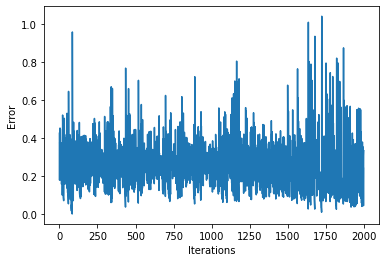

In [44]:
error = []

for epoch in range(0, 2000):
    
  # randomly select a training example
  entry = np.random.randint(4)
    
  x = X[entry,:]

  # 1. Feedforward

  Z_in = []
  Z_out = []
    
  # Each hidden unit sums its weighted input signals
  for j in range(0, number_hidden_units):
    Z_in.append(np.dot(x, v[j,:]))
    Z_out.append(sigmoid(Z_in[j])) # and applies its activation function to computer its output
    
  
  # We append the bias term to layer_1
  Z_out = np.append(1, Z_out)
    
  Y_in = []
  Y_out = []
    
  # Each output unit sums its weighted input signals
  for k in range(0, number_output_units):
    Y_in.append(np.dot(Z_out, w))
    Y_out.append(sigmoid(Y_in[k]))
      
  Y_in = Y_in[0]
  Y_out = Y_out[0]
  
   
  # 2. Backpropagation

  delta_Y = (y[entry] - Y_out)*sigmoid_prime(Y_in)
    
  delta_Y = np.array(delta_Y)
   
  #err = y[entry]-Y_out
  err = np.power(y[entry]-Y_out, 2)
            
  error.append(err)
        
  delta_Z_in = []
  delta_Z = []
    
  # Each hidden unit sums its delta inputs from previous layer
  for j in range(0, number_hidden_units):
    delta_Z_in.append(delta_Y*w[j+1])
    delta_Z.append(delta_Z_in[j]*sigmoid_prime(Z_in[j]))
      
      
  delta_Z = np.array(delta_Z)
    
        
  # 3. Weights adjustment
           
  tmp = alpha*delta_Y*Z_out
     
  v = v + alpha*delta_Z*x
  w = np.add(w.T, tmp)
    
  w = w.T
         
    
fig = plt.figure()
plt.plot(error)
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.show()